## Kelompok 9 2023A
1. Iqbal Syandana Arkan (23031554079)
2. Kevin Davindio Atha  (23031554173)
3. Kharisma Adhi Wibowo (23031554175)

## Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Sistem dan Peringatan
import os
import warnings
warnings.filterwarnings('ignore')

# Utilitas
import io
import joblib
from collections import Counter

# Manipulasi Data
import numpy as np
import pandas as pd

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Pengolahan Citra
import cv2
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor

# Google Colab
from google.colab import files

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Scikit-learn dan Imbalanced-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

## Collect Dataset & EDA

In [ ]:
full_dataset = "/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/lung cancer dataset 2"
normal_path =  "/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/lung cancer dataset 2/Normal cases"
jinak_path =  "/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/lung cancer dataset 2/Bengin cases"
ganas_path =  "/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/lung cancer dataset 2/Malignant cases"

Distribusi jumlah gambar per kelas

In [ ]:
print(len(os.listdir(normal_path)))
print(len(os.listdir(jinak_path)))
print(len(os.listdir(ganas_path)))

424
120
571


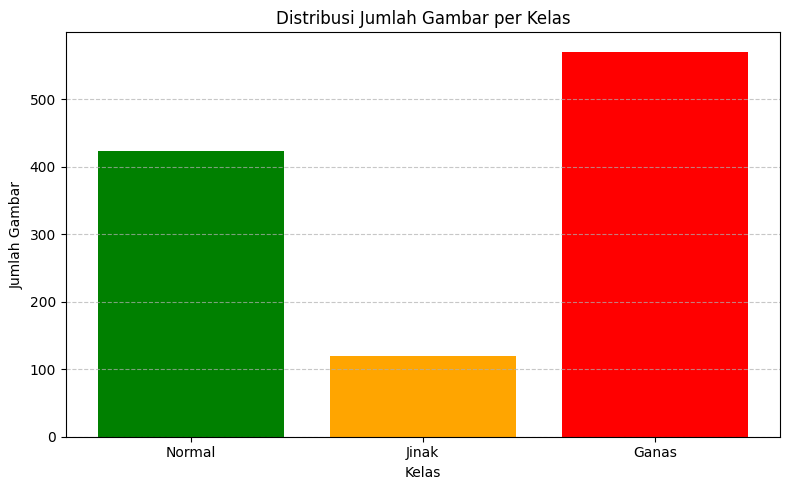

In [ ]:
def hitung_gambar(folder):
    return len([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

jumlah_normal = hitung_gambar(normal_path)
jumlah_jinak = hitung_gambar(jinak_path)
jumlah_ganas = hitung_gambar(ganas_path)

# Data untuk visualisasi
labels = ['Normal', 'Jinak', 'Ganas']
jumlah = [jumlah_normal, jumlah_jinak, jumlah_ganas]

# Visualisasi
plt.figure(figsize=(8, 5))
plt.bar(labels, jumlah, color=['green', 'orange', 'red'])
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Distribusi gambar berdasarkan ukuran gambar

In [ ]:
ukuran_gambar = []

# Telusuri semua gambar
for subdir, dirs, files in os.walk(full_dataset):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(subdir, file)
            try:
                with Image.open(img_path) as img:
                    ukuran_gambar.append(img.size)
            except Exception as e:
                print(f"Gagal membaca file {img_path}: {e}")

# Hitung jumlah kemunculan setiap ukuran
counter = Counter(ukuran_gambar)

# Tampilkan hasil
print("Jumlah gambar berdasarkan ukuran:")
for ukuran, jumlah in counter.items():
    print(f"Ukuran {ukuran}: {jumlah} gambar")


Jumlah gambar berdasarkan ukuran:
Ukuran (512, 512): 1045 gambar
Ukuran (506, 331): 1 gambar
Ukuran (511, 404): 1 gambar
Ukuran (623, 512): 40 gambar
Ukuran (801, 512): 28 gambar


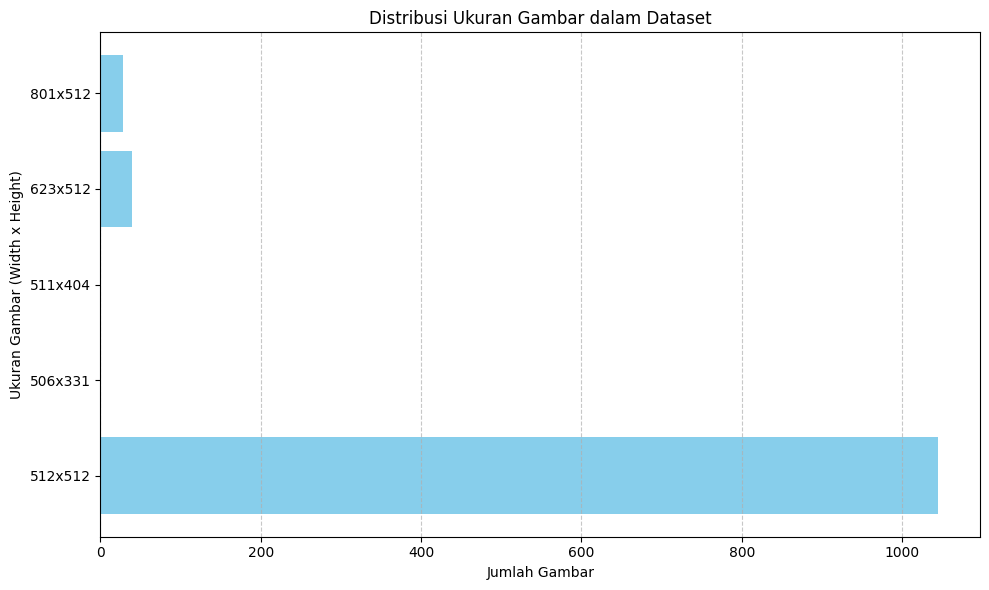

In [ ]:
ukuran_str = [f"{uk[0]}x{uk[1]}" for uk in counter.keys()]
jumlah = list(counter.values())

plt.figure(figsize=(10, 6))
plt.barh(ukuran_str, jumlah, color='skyblue')
plt.xlabel("Jumlah Gambar")
plt.ylabel("Ukuran Gambar (Width x Height)")
plt.title("Distribusi Ukuran Gambar dalam Dataset")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Load Images

In [ ]:
def load_images(directory):
    hasil =[Image.open(os.path.join(directory, filename)) for filename in os.listdir(directory)]
    hasil =[np.array(img) for img in hasil]
    return hasil

normal_images = load_images(normal_path)
jinak_images = load_images(jinak_path)
ganas_images =  load_images(ganas_path)

In [ ]:
normal_images[0].shape

(512, 512, 3)

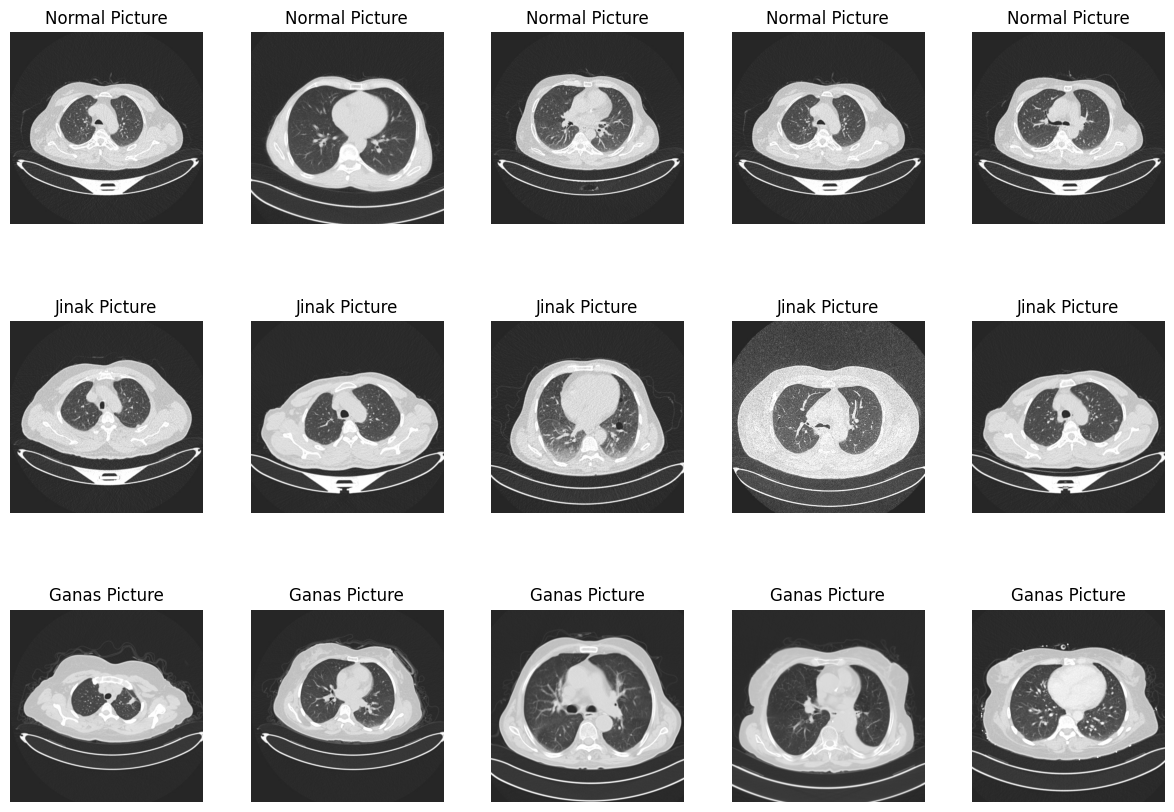

In [ ]:
# Plots 2 baris, 5 kolom
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# baris pertama
for i in range(5):
    axes[0, i].imshow(normal_images[i])
    axes[0, i].set_title('Normal Picture')
    axes[0, i].axis('off')

# baris kedua
for i in range(5):
    axes[1, i].imshow(jinak_images[i])
    axes[1, i].set_title('Jinak Picture')
    axes[1, i].axis('off')

# baris ketiga
for i in range(5):
    axes[2, i].imshow(ganas_images[i])
    axes[2, i].set_title('Ganas Picture')
    axes[2, i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

## Preprocessing

### Handling Imbalace Data

In [ ]:
# def augmentation(path_image,path_output,jumlah_file,jumlah_augmentasi):
#     # Folder gambar
#     folder_gambar = path_image
#     folder_output = path_output

#     # Buat folder output jika belum ada
#     os.makedirs(folder_output, exist_ok=True)

#     # ImageDataGenerator
#     datagen = ImageDataGenerator(
#         rotation_range=5,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=False,
#         fill_mode='nearest'
#     )

#     # Ambil file gambar
#     file_gambar = os.listdir(folder_gambar)[:jumlah_file]

#     # Augmentasi
#     for idx, nama_file in enumerate(file_gambar):
#         path = os.path.join(folder_gambar, nama_file)
#         image = load_img(path)
#         x = img_to_array(image)
#         x = np.expand_dims(x, axis=0)

#         gen = datagen.flow(x, batch_size=1)

#         for i in range(jumlah_augmentasi):
#             batch = next(gen)
#             img = array_to_img(batch[0])
#             nama_output = f"{idx+1}_{i+1}_1.jpg"
#             img.save(os.path.join(folder_output, nama_output))

In [ ]:
# folder_path = '/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/lung cancer dataset 2/'
# normal_area_path_aug = augmentation(f"{folder_path}Normal cases",f"{folder_path}Normal cases",147,1)
# jinak_area_path_aug = augmentation(f"{folder_path}Bengin cases",f"{folder_path}Bengin cases",91,1)
# normal_area_path_aug = augmentation(f"{folder_path}Malignant cases",f"{folder_path}Malignant cases",126,1)

In [ ]:
print(len(os.listdir(normal_path)))
print(len(os.listdir(jinak_path)))
print(len(os.listdir(ganas_path)))

571
571
571


### Resize Image

In [ ]:
def resize_images(images):
    hasil =[cv2.resize(img,(128,128)) for img in images]
    return hasil

normal_images_resize = resize_images(normal_images)
jinak_images_resize = resize_images(jinak_images)
ganas_images_resize =  resize_images(ganas_images)

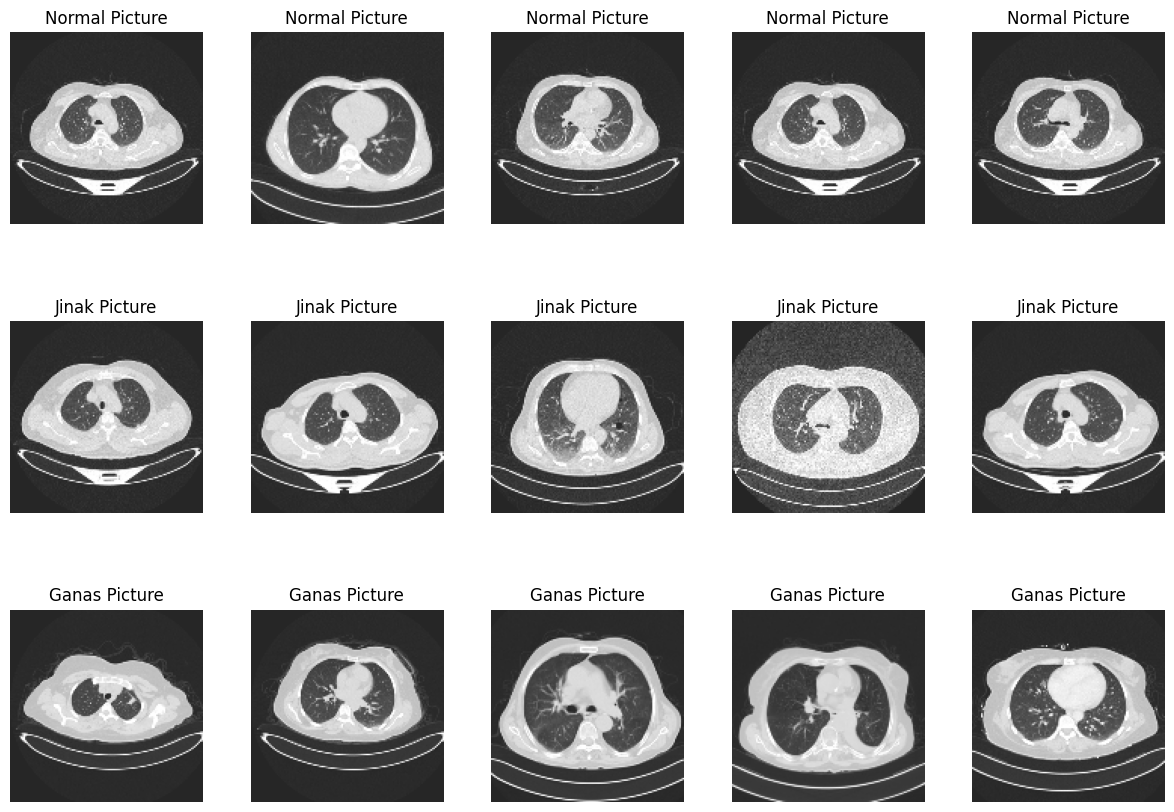

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for i in range(5):
    axes[0, i].imshow(normal_images_resize[i])
    axes[0, i].set_title('Normal Picture')
    axes[0, i].axis('off')

for i in range(5):
    axes[1, i].imshow(jinak_images_resize[i])
    axes[1, i].set_title('Jinak Picture')
    axes[1, i].axis('off')

for i in range(5):
    axes[2, i].imshow(ganas_images_resize[i])
    axes[2, i].set_title('Ganas Picture')
    axes[2, i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
def get_image_sizes(images):
    sizes = [img.shape[:2] for img in images]
    return sizes

normal_sizes = get_image_sizes(normal_images_resize)
jinak_sizes = get_image_sizes(jinak_images_resize)
ganas_sizes = get_image_sizes(ganas_images_resize)
full_size = normal_sizes + jinak_sizes + ganas_sizes

In [ ]:
normal_sizes[1]

(128, 128)

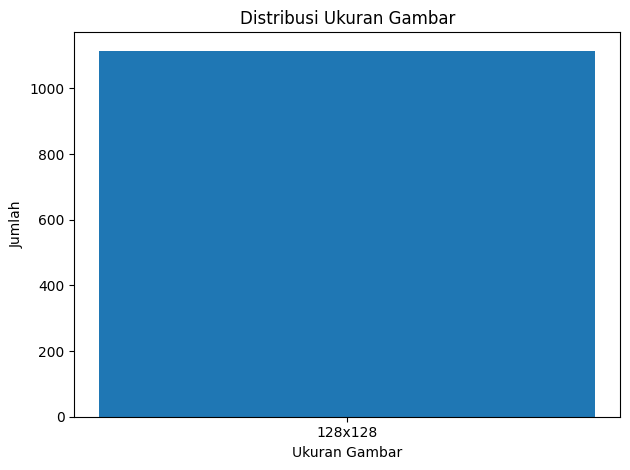

In [ ]:
from collections import Counter

data_str = [f"{w}x{h}" for (w, h) in full_size]

# Hitung distribusi
counter = Counter(data_str)

# Plot bar chart
plt.bar(counter.keys(), counter.values())
plt.xlabel("Ukuran Gambar")
plt.ylabel("Jumlah")
plt.title("Distribusi Ukuran Gambar")
plt.tight_layout()
plt.show()

In [ ]:
normal_images_resize[0].shape

(128, 128, 3)

### Noise Reduction

In [ ]:
def apply_gaussian_filter(images, kernel_size=(5, 5), sigma=0):
    hasil = [cv2.GaussianBlur(img, kernel_size, sigma) for img in images]
    visualize_resize(images[:5],hasil[:5])
    return hasil

def visualize_resize(before,after):
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(5):
        axes[0, i].imshow(before[i])
        axes[0, i].set_title('Sebelum')
        axes[0, i].axis('off')

    for i in range(5):
        axes[1, i].imshow(after[i])
        axes[1, i].set_title('Sesudah')
        axes[1, i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

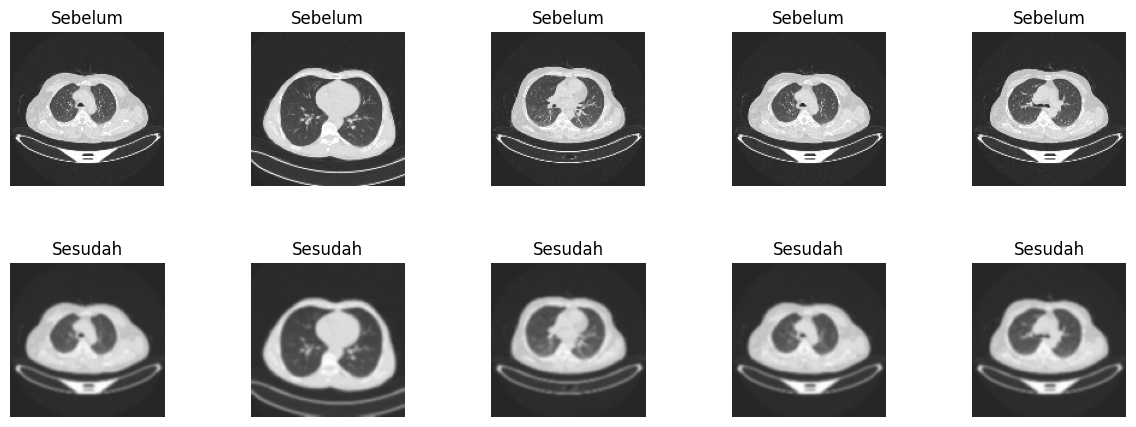

In [ ]:
normal_images_filter = apply_gaussian_filter(normal_images_resize)

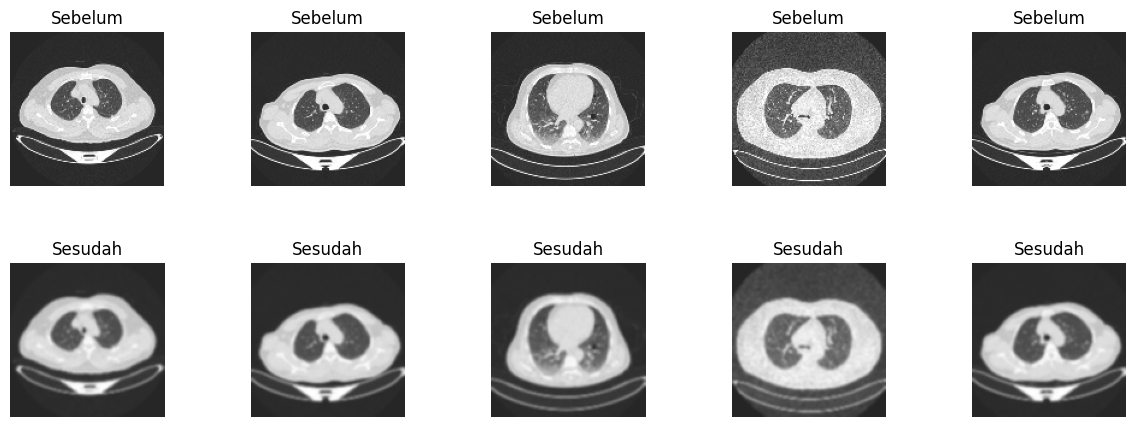

In [ ]:
jinak_images_filter = apply_gaussian_filter(jinak_images_resize)

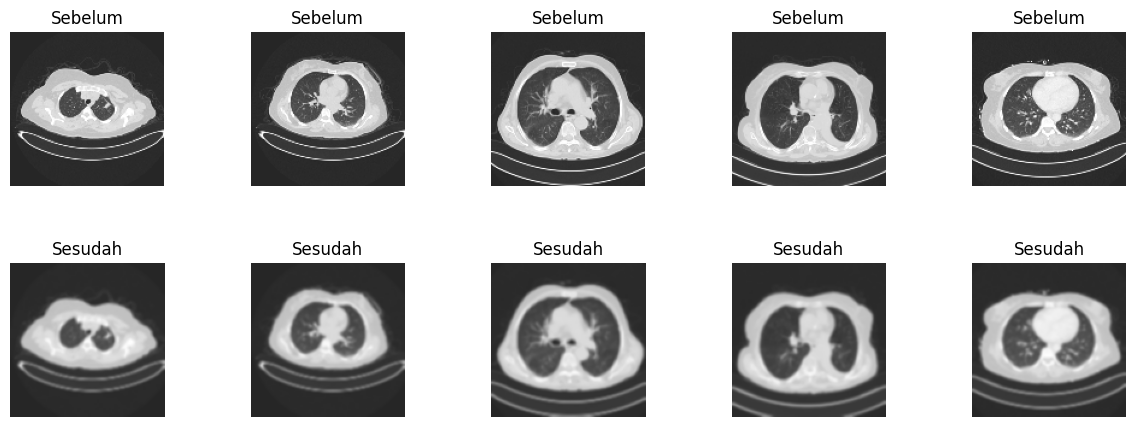

In [ ]:
ganas_images_filter = apply_gaussian_filter(ganas_images_resize)

### Erosion Operation

In [ ]:
def apply_erosion(images, kernel_size=(3, 3), iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    hasil = [cv2.erode(img, kernel, iterations=iterations) for img in images]
    visualize_erosion(images[:5],hasil[:5])
    return hasil

def visualize_erosion(before,after):
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(5):
        axes[0, i].imshow(before[i])
        axes[0, i].set_title('Sebelum')
        axes[0, i].axis('off')

    for i in range(5):
        axes[1, i].imshow(after[i])
        axes[1, i].set_title('Sesudah')
        axes[1, i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

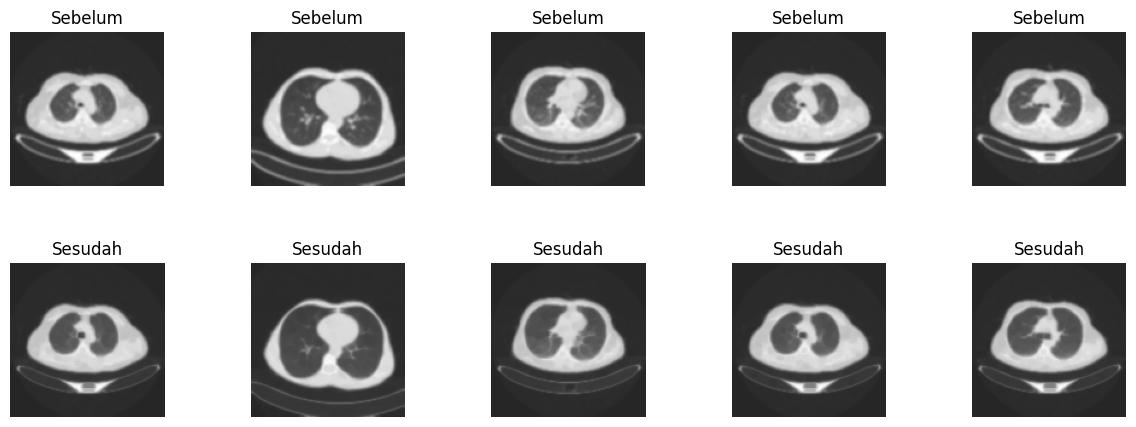

In [ ]:
normal_images_erosion = apply_erosion(normal_images_filter)

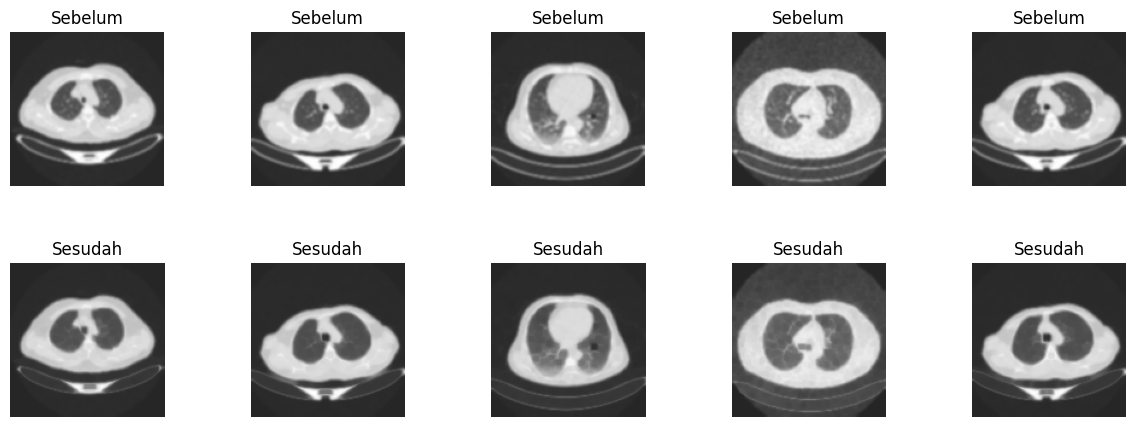

In [ ]:
jinak_images_erosion = apply_erosion(jinak_images_filter)

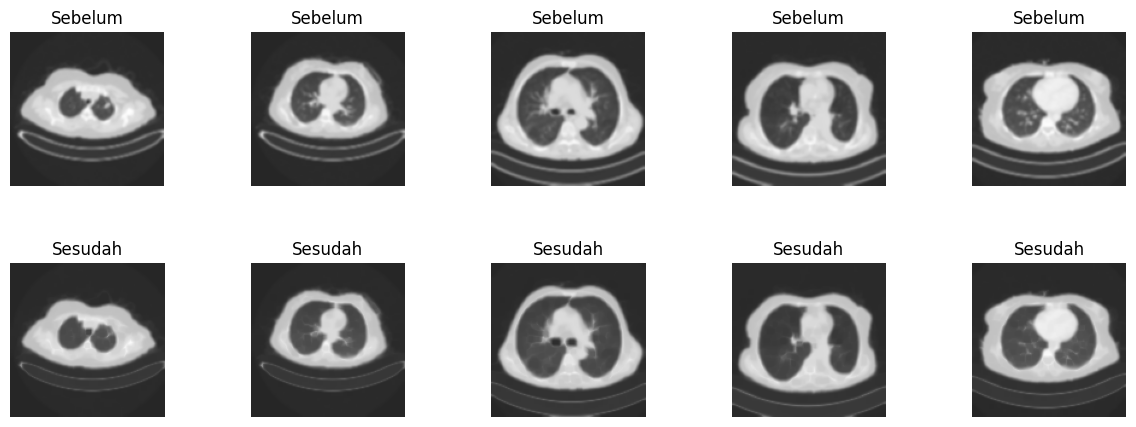

In [ ]:
ganas_images_erosion = apply_erosion(ganas_images_filter)

### Segmentasi stage

In [ ]:
def define_lung_areas(images, threshold=100):
    hasil = []
    for img in images:
        if len(img.shape) == 2:
            gray = img
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

        masked_img = cv2.bitwise_and(gray, gray, mask=mask)

        hasil.append(masked_img)

    visualize_lung_areas(images[:5], hasil[:5])
    return hasil

def visualize_lung_areas(before,after):
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(5):
        axes[0, i].imshow(before[i],cmap='gray')
        axes[0, i].set_title('Sebelum')
        axes[0, i].axis('off')

    for i in range(5):
        axes[1, i].imshow(after[i],cmap='gray')
        axes[1, i].set_title('Sesudah')
        axes[1, i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

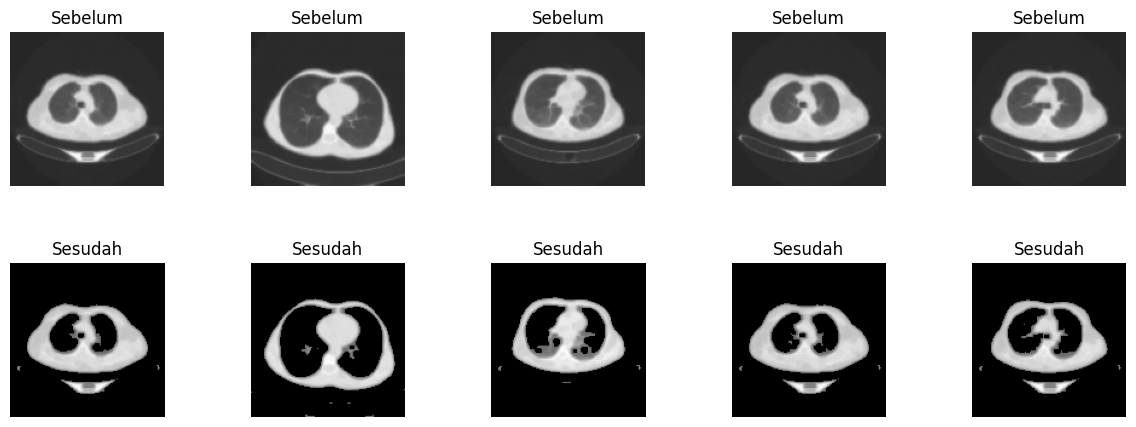

In [ ]:
normal_images_lung_area = define_lung_areas(normal_images_erosion)

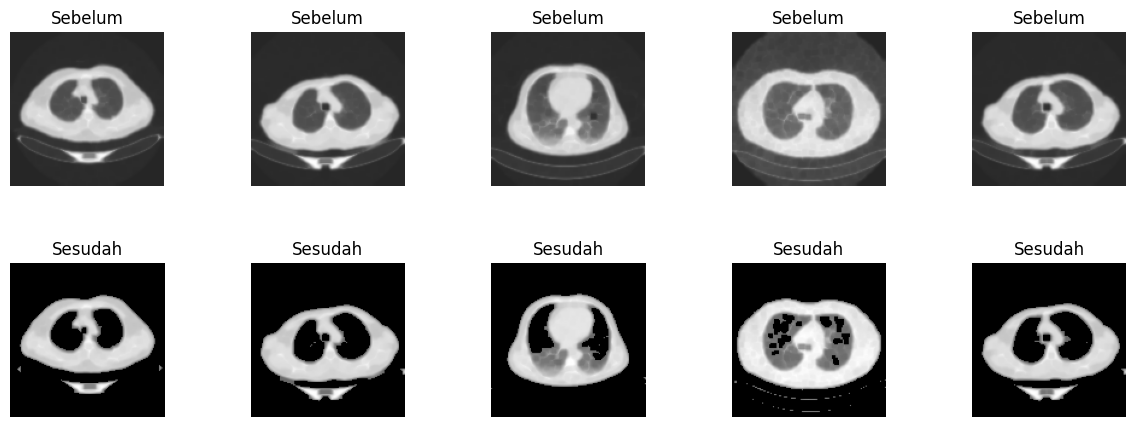

In [ ]:
jinak_images_lung_area = define_lung_areas(jinak_images_erosion)

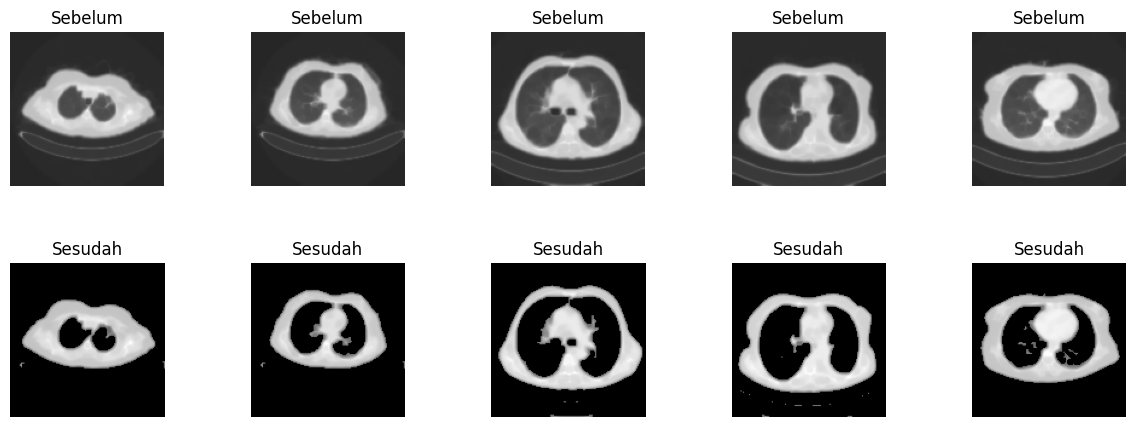

In [ ]:
ganas_images_lung_area = define_lung_areas(ganas_images_erosion)

In [ ]:
def apply_otsu_thresholding(images):
    hasil = []

    for img in images:
        _, segmented = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        hasil.append(segmented)

    visualize_segmentation(images[:5], hasil[:5])  # Visualisasi hasil segmentasi
    return hasil

def visualize_segmentation(before,after):
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    for i in range(5):
        axes[0, i].imshow(before[i],cmap='gray')
        axes[0, i].set_title('Sebelum')
        axes[0, i].axis('off')

    for i in range(5):
        axes[1, i].imshow(after[i],cmap='gray')
        axes[1, i].set_title('Sesudah')
        axes[1, i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

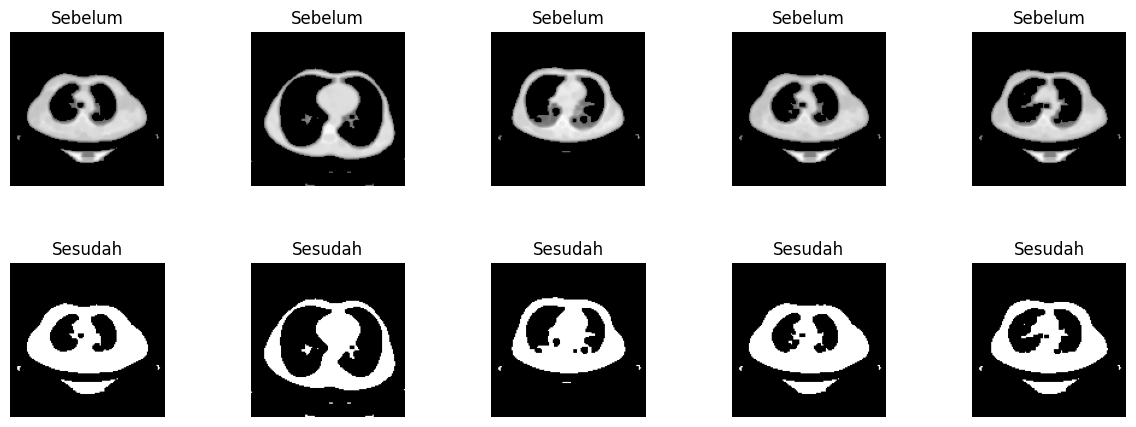

In [ ]:
normal_images_segmentation = apply_otsu_thresholding(normal_images_lung_area)

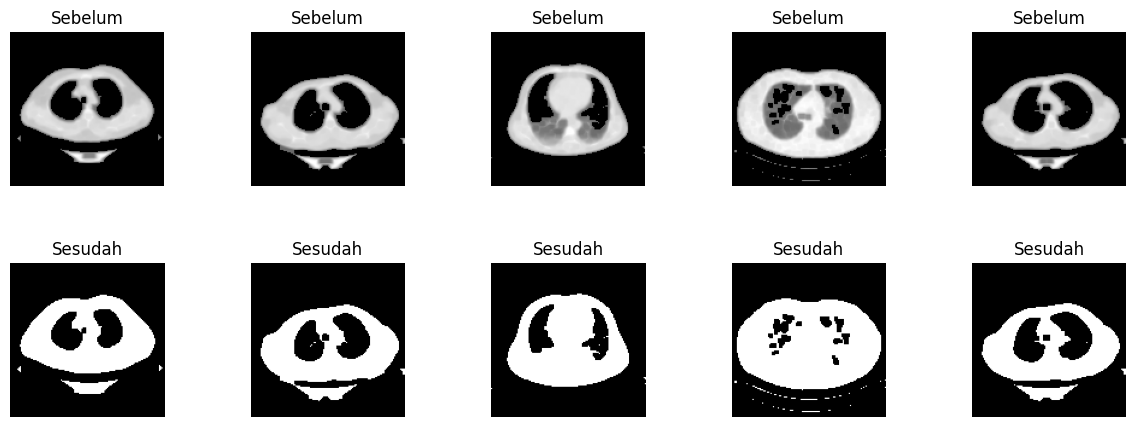

In [ ]:
jinak_images_segmentation = apply_otsu_thresholding(jinak_images_lung_area)

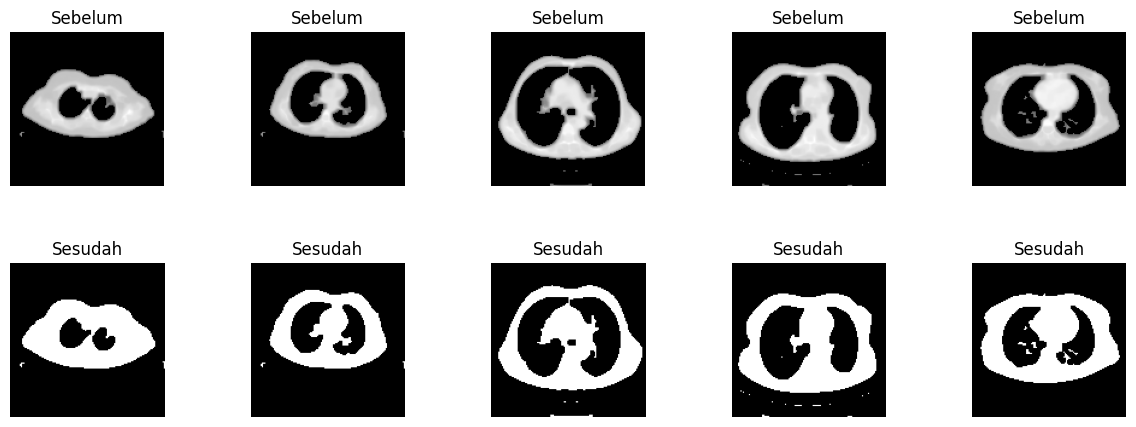

In [ ]:
ganas_images_segmentation = apply_otsu_thresholding(ganas_images_lung_area)

## Model

### Machine Learning

#### Features Extraction

In [ ]:
def extract_glcm_gabor_features(images, distances=[1], angles=[0], levels=256,
                                glcm_props=['contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'dissimilarity'],
                                gabor_frequencies=[0.1, 0.2, 0.3], gabor_thetas=[0, np.pi/4, np.pi/2]):
    feature_list = []

    for img in images:
        # Konversi ke grayscale
        if len(img.shape) == 2:
            gray = img
        elif img.shape[2] == 1:
            gray = img[:, :, 0]
        else:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if gray.max() >= levels:
            gray = (gray / (gray.max() + 1) * levels).astype(np.uint8)

        features = []

        # GLCM
        glcm = graycomatrix(gray,
                            distances=distances,
                            angles=angles,
                            levels=levels,
                            symmetric=True,
                            normed=True)

        for prop in glcm_props:
            try:
                val = graycoprops(glcm, prop)[0, 0]
                features.append(val.item())
            except ValueError:
                print(f"[GLCM] Properti '{prop}' gagal dihitung.")
                features.append(np.nan)

        # Ekstraksi fitur Gabor
        gabor_amp_total = 0
        gabor_phase_sum = 0
        count = 0

        for freq in gabor_frequencies:
            for theta in gabor_thetas:
                real, imag = gabor(gray, frequency=freq, theta=theta)
                amplitude = np.sqrt(real**2 + imag**2)
                phase = np.arctan2(imag, real)

                gabor_amp_total += amplitude.mean()
                gabor_phase_sum += phase.mean()
                count += 1

        # Rata-rata amplitude dan phase
        gabor_amp_mean = float(gabor_amp_total / count)
        gabor_phase_mean = float(gabor_phase_sum / count)

        features.extend([gabor_amp_mean, gabor_phase_mean])

        feature_list.append(features)

    return feature_list


In [ ]:
normal_images_ekstraction = extract_glcm_gabor_features(normal_images_segmentation)
jinak_images_ekstraction = extract_glcm_gabor_features(jinak_images_segmentation)
ganas_images_ekstraction = extract_glcm_gabor_features(ganas_images_segmentation)

In [ ]:
normal_images_ekstraction[0]

[1216.0187007874017,
 0.9812995001878111,
 0.7916927210974684,
 0.9473026606833967,
 0.6267773646387138,
 4.768700787401575,
 1.86328125,
 0.26220703125]

#### Labeling

In [ ]:
def assign_labels(normal_images, jinak_images, ganas_images):
    normal_labels = np.zeros(len(normal_images))
    jinak_labels = np.ones(len(jinak_images))
    ganas_labels = np.full(len(ganas_images), 2)
    return normal_labels, jinak_labels, ganas_labels

normal_labels, jinak_labels, ganas_labels = assign_labels(normal_images_ekstraction, jinak_images_ekstraction, ganas_images_ekstraction)

In [ ]:
normal_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
jinak_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [ ]:
ganas_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
data_full_images = normal_images_ekstraction + jinak_images_ekstraction + ganas_images_ekstraction
labels = np.concatenate([normal_labels, jinak_labels, ganas_labels], axis=0)

In [ ]:
data_full_images[:5]

[[1216.0187007874017,
  0.9812995001878111,
  0.7916927210974684,
  0.9473026606833967,
  0.6267773646387138,
  4.768700787401575,
  1.86328125,
  0.26220703125],
 [1776.027312992126,
  0.9726874279058819,
  0.796546463634355,
  0.9194180412179493,
  0.6344862687283968,
  6.964812992125984,
  2.240234375,
  0.324951171875],
 [1312.0201771653542,
  0.9798231449394803,
  0.8070186626678353,
  0.9386620629346655,
  0.6512791218941812,
  5.145177165354331,
  1.8701171875,
  0.256103515625],
 [1280.01968503937,
  0.9803152633555905,
  0.7906761742922854,
  0.944632415424288,
  0.6251688125934844,
  5.019685039370079,
  1.92578125,
  0.2666015625],
 [1368.0210383858268,
  0.9789619377112874,
  0.8014663459806508,
  0.9375819134993446,
  0.6423483037395763,
  5.364788385826772,
  2.11328125,
  0.28564453125]]

In [ ]:
len(data_full_images)

1115

In [ ]:
len(labels)

1115

#### Split Data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ubah data dan label menjadi array
X = np.array(data_full_images)
y = np.array(labels)

# Split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[1.35202079e+03, 9.79207997e-01, 7.09152791e-01, ...,
        5.30204232e+00, 2.07812500e+00, 2.93945312e-01],
       [1.31202018e+03, 9.79823145e-01, 7.81434007e-01, ...,
        5.14517717e+00, 1.81640625e+00, 2.55371094e-01],
       [1.37602116e+03, 9.78838908e-01, 7.73053189e-01, ...,
        5.39616142e+00, 2.00781250e+00, 2.77587891e-01],
       ...,
       [7.84012057e+02, 9.87943099e-01, 6.99704948e-01, ...,
        3.07455709e+00, 1.60449219e+00, 2.31323242e-01],
       [1.82802811e+03, 9.71887735e-01, 7.67351291e-01, ...,
        7.16873770e+00, 2.45703125e+00, 3.34960938e-01],
       [9.44014518e+02, 9.85482507e-01, 7.75461112e-01, ...,
        3.70201772e+00, 1.77050781e+00, 2.46948242e-01]])

In [ ]:
y_train

array([0., 0., 1., 0., 2., 0., 1., 2., 2., 2., 2., 0., 0., 0., 2., 0., 2.,
       0., 2., 2., 2., 0., 0., 1., 1., 1., 2., 2., 2., 2., 2., 0., 2., 1.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
       2., 1., 2., 2., 0., 2., 1., 2., 2., 2., 1., 1., 0., 2., 0., 2., 0.,
       2., 0., 2., 2., 0., 0., 2., 2., 0., 0., 2., 1., 1., 0., 2., 0., 2.,
       2., 2., 2., 0., 2., 0., 2., 2., 2., 2., 0., 0., 0., 0., 2., 0., 2.,
       2., 2., 2., 0., 2., 2., 0., 1., 2., 2., 0., 2., 0., 2., 0., 0., 1.,
       2., 0., 1., 2., 2., 0., 2., 1., 0., 0., 1., 0., 2., 0., 0., 2., 2.,
       1., 0., 0., 2., 0., 1., 1., 2., 2., 1., 2., 2., 0., 2., 0., 0., 2.,
       0., 0., 2., 2., 0., 1., 1., 0., 0., 2., 0., 2., 0., 2., 0., 2., 2.,
       2., 0., 2., 1., 0., 2., 0., 2., 0., 2., 0., 2., 0., 0., 0., 2., 2.,
       2., 2., 2., 0., 1., 0., 1., 2., 0., 2., 2., 0., 2., 2., 2., 2., 0.,
       2., 2., 0., 2., 2., 1., 2., 0., 1., 0., 2., 0., 2., 0., 0., 2., 1.,
       2., 2., 2., 2., 2.

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

# Parameter awal
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Hyperparameter tuning Gridsearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(
    rf, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1
)
grid_search.fit(X_train, y_train)

# Model terbaik
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluasi
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Random Forest (GLCM): {accuracy:.2f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Akurasi Random Forest (GLCM): 0.82

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82        88
         1.0       0.78      0.54      0.64        26
         2.0       0.83      0.87      0.85       109

    accuracy                           0.82       223
   macro avg       0.80      0.75      0.77       223
weighted avg       0.81      0.82      0.81       223

Confusion Matrix:
[[73  2 13]
 [ 5 14  7]
 [12  2 95]]


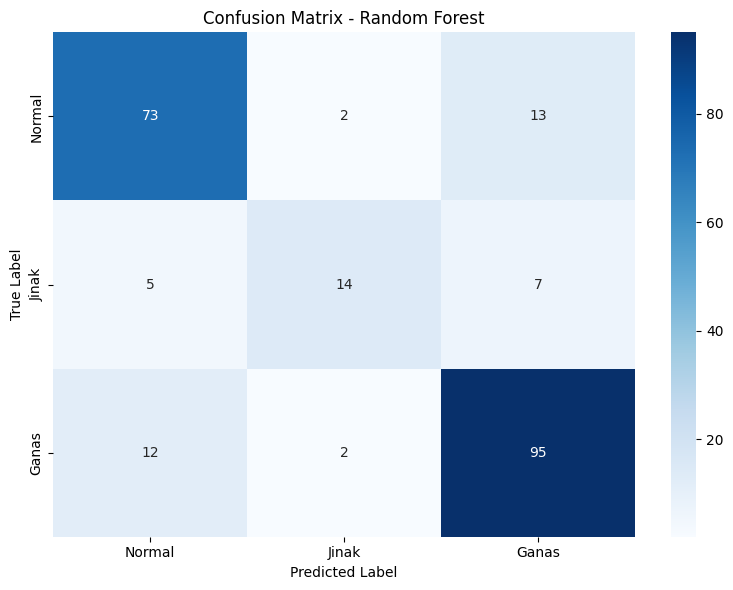

In [ ]:
plt.figure(figsize=(8,6))
class_labels = ['Normal', 'Jinak', 'Ganas']
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### Save Model Random Forest

In [ ]:
import joblib

save_path = '/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/random_forest_model_baru_2.pkl'

# Simpan model terbaik Random Forest
joblib.dump(best_model, save_path)
print(f"Model disimpan di: {save_path}")

Model disimpan di: /content/drive/MyDrive/projek_semester_4/PMD/projek UAS/random_forest_model_baru_2.pkl


### Deep Learning

#### labeling

In [ ]:
def assign_labels(normal_images, jinak_images, ganas_images):
    normal_labels = np.zeros(len(normal_images))
    jinak_labels = np.ones(len(jinak_images))
    ganas_labels = np.full(len(ganas_images), 2)
    return normal_labels, jinak_labels, ganas_labels

normal_labels, jinak_labels, ganas_labels = assign_labels(normal_images_segmentation, jinak_images_segmentation, ganas_images_segmentation)

In [ ]:
normal_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
jinak_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [ ]:
ganas_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
data_full_images = normal_images_segmentation + jinak_images_segmentation + ganas_images_segmentation
labels = np.concatenate([normal_labels, jinak_labels, ganas_labels], axis=0)

In [ ]:
data_full_images[:5]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

In [ ]:
len(data_full_images)

1115

In [ ]:
len(labels)

1115

#### Splitting data

In [ ]:
X = np.array(data_full_images)
y = np.array(labels)

#### CNN

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Stratified K-Fold
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Path penyimpanan model terbaik
save_path = '/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/model_cnn_baru_2.keras'

# Variabel untuk menyimpan akurasi terbaik
best_accuracy = 0.0

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1), padding='valid'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fold = 1
acc_per_fold = []

for train_index, val_index in kf.split(X, y):
    print(f"\n🔁 Fold {fold}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model()

    # Simpan model sementara
    temp_model_path = f'/content/model_fold_{fold}.keras'
    checkpoint = ModelCheckpoint(
        temp_model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        verbose=1,
        callbacks=[checkpoint]
    )

    # Load model terbaik
    model.load_weights(temp_model_path)
    score = model.evaluate(X_val, y_val, verbose=0)
    acc = score[1]
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    acc_per_fold.append(acc)

    # Simpan model jika lebih baik dari sebelumnya
    if acc > best_accuracy:
        best_accuracy = acc
        model.save(save_path)
        print(f"Model terbaik disimpan ke: {save_path}")

    fold += 1

print(f"\nAkurasi rata-rata dari {k} fold: {np.mean(acc_per_fold):.4f}")
print(f"Model terbaik memiliki akurasi: {best_accuracy:.4f}")


🔁 Fold 1
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.5013 - loss: 1012.3699
Epoch 1: val_accuracy improved from -inf to 0.76233, saving model to /content/model_fold_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5043 - loss: 997.9572 - val_accuracy: 0.7623 - val_loss: 38.7937
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.8030 - loss: 19.6662
Epoch 2: val_accuracy improved from 0.76233 to 0.84305, saving model to /content/model_fold_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8033 - loss: 19.3045 - val_accuracy: 0.8430 - val_loss: 0.5538
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8498 - loss: 0.5649
Epoch 3: val_accuracy improved from 0.84305 to 0.88789, saving model to /content/model_fold_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8496 - loss: 0.5661 - val_accuracy: 0.8879 - val_loss: 0.2786
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.8823 - loss: 1.3

Save Model

## Testing

In [ ]:
# Load model random forest
model_rf = joblib.load('/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/random_forest_model_baru_2.pkl')

In [ ]:
# Load model CNN
model_cnn = load_model('/content/drive/MyDrive/projek_semester_4/PMD/projek UAS/model_cnn_baru_2.keras')

In [ ]:
def preprocessing_image(image_array, resize_dim=(128, 128), blur_kernel=(5, 5), blur_sigma=0, erosion_kernel=(3, 3), erosion_iterations=1, lung_threshold=100):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, erosion_kernel)

    # Resize
    resized = cv2.resize(image_array, resize_dim)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(resized, blur_kernel, blur_sigma)

    # Erosion
    eroded = cv2.erode(blurred, kernel, iterations=erosion_iterations)

    # ubah ke grayscale
    gray = eroded if len(eroded.shape) == 2 else cv2.cvtColor(eroded, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, mask = cv2.threshold(gray, lung_threshold, 255, cv2.THRESH_BINARY)
    masked_img = cv2.bitwise_and(gray, gray, mask=mask)

    return masked_img

Saving Malignant case (11).jpg to Malignant case (11).jpg


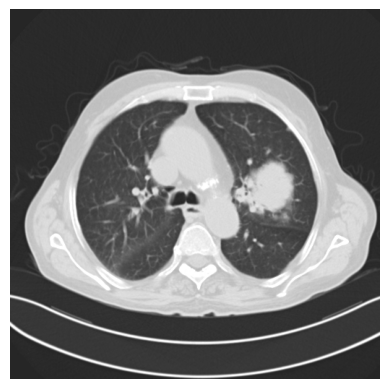

2.0
Ganas


In [ ]:
def predict_image_rf(image_bytes):
    img = Image.open(io.BytesIO(image_bytes))
    img_array = np.array(img)
    preprocessed_img = preprocessing_image(img_array)

    # GLCM
    features = extract_glcm_gabor_features([preprocessed_img])

    features_array = np.array(features)
    prediction_label_index = model_rf.predict(features_array)[0]
    print(prediction_label_index)

    # Prediksi Kelas
    if prediction_label_index == 0:
        return "Normal"
    elif prediction_label_index == 1:
        return "Jinak"
    elif prediction_label_index == 2:
        return "Ganas"
    else:
        return "unkown"

# Upload files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]
img = Image.open(io.BytesIO(image_bytes))

plt.imshow(img)
plt.axis('off')
plt.show()

result = predict_image_rf(image_bytes)
print(result)

Saving Normal case (300).jpg to Normal case (300).jpg


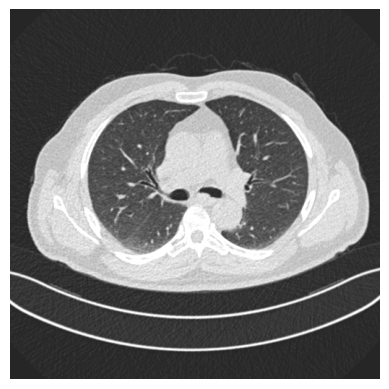

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction probabilities: [[0.39753014 0.28637755 0.31609234]]
Predicted label index: 0
Normal


In [ ]:
def predict_image_cnn(image_bytes):
    img = Image.open(io.BytesIO(image_bytes))
    img_array = np.array(img)
    preprocessed_img = preprocessing_image(img_array)

    # channel dimension.
    preprocessed_img_cnn_input = np.expand_dims(preprocessed_img, axis=0)
    preprocessed_img_cnn_input = np.expand_dims(preprocessed_img_cnn_input, axis=-1)

    preprocessed_img_cnn_input = preprocessed_img_cnn_input.astype(np.float32) / 255.0

    # CNN model
    predictions = model_cnn.predict(preprocessed_img_cnn_input)

    # Prediksi Kelas
    prediction_label_index = np.argmax(predictions, axis=1)[0]
    print(f"Prediction probabilities: {predictions}")
    print(f"Predicted label index: {prediction_label_index}")

    if prediction_label_index == 0:
        return "Normal"
    elif prediction_label_index == 1:
        return "Jinak"
    elif prediction_label_index == 2:
        return "Ganas"
    else:
        return "Unknown"

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]
img = Image.open(io.BytesIO(image_bytes))

plt.imshow(img)
plt.axis('off')
plt.show()

result = predict_image_cnn(image_bytes)
print(result)